In [1]:
import os
os.getpid()

74101

In [2]:
import os
os.environ['DISPLAY'] = ":1"

In [199]:
connection.close()

In [3]:
import sys
sys.path.append("/home/dcsoft/clineage/")
import clineage.wsgi

from sampling.models import Individual
from sequencing.calling.queries.mutation_maps import transpose_dict, filter_mutation_map
from sequencing.phylo.data_querying import get_multi_run_srs, filter_classifying_microsatelites, \
cell_labeler, filter_by_minimal_group_size, query_calling_dict_bi, query_calling_dict_mono

from sequencing.phylo.utils import get_cells_group_map
from sequencing.phylo.plotting import minimal_noa_plot
from sequencing.phylo.FastTree_wrapper import create_FastTree_fasta_file, run_fastree, unroot_FastTree_tree
import matplotlib.pylab as plt
%matplotlib inline
from IPython.display import display, Image

from sequencing.analysis.models import SampleReads, AdamHistogram, FullMSVHistogram, HistogramEntryReads
from frogress import bar

def draw(tree, multi_run_srs, output_prefix):
    cells_group_map_sr = get_cells_group_map(multi_run_srs, by_cell_id=False)
#     cells_group_map_sr2 = {sr:group if group in ['CD3bulk', 'endothelial', 'CD31', 'Kera','Keratinocyte','Keratinocytes'] else 'Blood' for sr, group in cells_group_map_sr.items()}
    clustering_dict = minimal_noa_plot(tree, cells_group_map_sr, output_prefix)
    display(Image(filename=output_prefix + '.png'))
    print(clustering_dict)


def fastree(td, rldr, ind_name, title, min_group_size, multi_run_srs, rldr_group):
    fasta_path = create_FastTree_fasta_file(td, rldr, ind_name, title, min_group_size, rldr_group)
    newick_output_files = run_fastree(fasta_path, ind_name, title, min_group_size, rldr_group)
    
    print("Finished fastTree")
    for newick_output_file in newick_output_files:
        output_prefix = newick_output_file[:-len('.newick')]
        tree = unroot_FastTree_tree(newick_output_file)
        draw(tree, multi_run_srs, output_prefix)
    return fasta_path, newick_output_file

In [4]:
import pandas as pd
# hists_df = pd.read_pickle('/home/dcsoft/s/Ofir/df_m_sr_panel_bi_2019_12.pickle')
# hists_df = pd.read_pickle('/home/dcsoft/s/Ofir/df_m_sr_panel_mono_pseudo_2019_12_04_merged_ac_only.pickle')
# hists_df = pd.read_pickle('/home/dcsoft/s/Ofir/df_m_sr_panel_mono_pseudo_2019_12_04_merged_ac_only_filtered_hist.pickle')
# hists_df = pd.read_pickle('/home/dcsoft/s/Ofir/df_m_healthy_klein_with_841-12_kd_with_prf.pickle')
# hists_df = pd.read_pickle('/home/dcsoft/s/nn_project/df_m_healthy_klein_kd_with_kd.pickle')
hists_df = pd.read_pickle('/home/dcsoft/s/Ofir/old_ofir/hists_df_2020_01_13_updated.pickle')
# hists_df = pd.read_pickle('/home/dcsoft/s/Ofir/exvivo_df_new.pickle')
# hists_df = pd.read_pickle('/home/dcsoft/s/Ofir/full_ind_df_with_kd_all_20200519.pickle')
# hists_df = pd.read_pickle('/home/dcsoft/s/Ofir/hists_df_775-13_2020_03_31.pickle')
# hists_df = pd.read_pickle('/home/dcsoft/s/Ofir/pickles/lcl465_sf-s_2020_02_10_nova2_merged.pickle')
# hists_df = pd.read_pickle('/home/dcsoft/s/Ofir/timo_merged.pickle')
# hists_df = pd.read_pickle('/home/dcsoft/s/Ofir/walsh_nova2_merged.pickle')

In [5]:
def cosine_score_to_dist(alpha):
    return 2*np.sin(np.arccos(1-alpha)/2)

def dist_to_cosing_score(d):
    return 1-np.cos(2*np.arcsin(d/2))

In [17]:
from sklearn.neighbors import KDTree
import numpy as np

from sequencing.calling.models import ProportionalSimCorScheme
from sequencing.calling.models import HighestPeaksProximityRatioFilteredBiSimCorSchemeModel, HighestPeaksMonoSimCorSchemeModel, HighestPeaksProximityRatioFilteredBiSimCorSchemeModelDot, HighestPeaksMonoSimCorSchemeModelDot
ac_schema_bi = HighestPeaksProximityRatioFilteredBiSimCorSchemeModelDot.objects.get(name__contains='dot')
# ac_schema_bi_dot = HighestPeaksProximityRatioFilteredBiSimCorSchemeModelDot.objects.get(name__contains='dot')

# ac_schema_bi = ProportionalSimCorScheme.objects.get(name__contains='AC')

L2normalized_vecs = [(sh._vec/np.linalg.norm(sh._vec, ord=2))[3:40] for sh in bar(ac_schema_bi.sim_hists_space)]
print()
hist_map = [sh for sh in bar(ac_schema_bi.sim_hists_space)]

[##########] | Progress: 116730 | Time: 1min10s | ETA: --
[##########] | Progress: 116730 | Time: 1min5s | ETA: --

In [18]:
LEAF_SIZE = 100 # optimization shows 50-110 are almost the same
kdtree = KDTree(np.array(L2normalized_vecs), leaf_size=LEAF_SIZE)
print("finished building tree")

finished building tree


In [6]:
from collections import namedtuple
import numpy as np

HistKey = namedtuple('HistKey',['histogram_id', 'microsatellite_id', 'sample_reads_id'])
def extract_normalized_vectors(df3_40):
    vech_keys = []
    vech_values = []
    for k, r in bar(df3_40.iterrows()):
        vech = np.array(r)
        vech_normed = vech/np.linalg.norm(vech, ord=2)
        if np.any(np.isnan(vech_normed)):
            print('warning nans in {}'.format(k))
            continue
        vech_keys.append(HistKey(*k))
        vech_values.append(vech_normed)
    return vech_keys, vech_values

Call = namedtuple('Call',['hist','conf'])
def map_tree_query(ind, dist, vech_keys):
    called = {}
    for (ind0, dist0, k) in bar(zip(ind, dist, vech_keys)):
        if len(ind0)!=0:
            imin = np.argmin(dist0)
            called[k] = Call(hist_map[ind0[imin]], dist_to_cosing_score(dist0[imin]))
    return called

# Haplotyping

In [7]:
from collections import Counter
from sequencing.calling.hist import Histogram as dHistogram
from sequencing.calling.simcor.hist_analysis import better_get_far_apart_highest_peaks
from sequencing.calling.simcor.calling import get_peaks_ranges


class BaseHaplotypingException(Exception):
    pass


class EmptyHistogramException(BaseHaplotypingException):
    pass


class IllegalPeaksException(BaseHaplotypingException):
    pass


class EmptyCallingAssignmentException(BaseHaplotypingException):
    pass


def get_flat_data(df, a1_col='a1', a2_col='a2'):
    h = dHistogram(
        Counter(
            np.concatenate([
                df[a1_col].dropna().values, 
                df[a2_col].dropna().values
            ]).astype(int)))
    if len(h.items()) == 0:
        raise EmptyHistogramException()
    return h


def find_peaks(h, minimal_distance_between_peaks=3, min_prop=0.2):
    peaks = better_get_far_apart_highest_peaks(
            h,
            minimal_distance_between_peaks=minimal_distance_between_peaks,
            min_prop=min_prop
        )
    if peaks is None or len(peaks) > 2:
        raise IllegalPeaksException()
    return peaks
    
    
def get_parser_by_peaks_range(peaks, max_distance_from_peak=2):
    peaks.sort()
    peaks_by_range = {p: prange for p, prange in zip(peaks, get_peaks_ranges(peaks, max_distance_from_peak))}
    def parser(k, row, a1_col='a1', a2_col='a2'):
        assigned_alleles = dict()
        for a in [row[a1_col], row[a2_col]]:
            for peak, peak_range in peaks_by_range.items():
                if a in peak_range:
                    assigned_alleles[a] = peak
                    break
            else:
                pass  # TODO: allele was not assigned to a window, consider exception
        return assigned_alleles
    return parser


def apply_parser(df, parser, a1_col='a1', a2_col='a2'):
    calling_assignments = dict()
    for k, row in df.iterrows():
        assignment = parser(k, row, a1_col=a1_col, a2_col=a2_col)
        calling_assignments[k] = assignment
    if calling_assignments is None:
        raise EmptyCallingAssignmentException()
    return calling_assignments


def invert_calling_assignments(calling_assignments, average=False):
    ica = dict()
    for k in calling_assignments:
        inverted_dict = dict()
        for allele, slot in calling_assignments[k].items():
            inverted_dict.setdefault(slot, []).append(allele)
        if average:
            ica[HistKey(*k).sample_reads_id] = {k: sum(v)//len(v) for k, v in inverted_dict.items()}
        else:
            ica[HistKey(*k).sample_reads_id] = {k: v[0] for k, v in inverted_dict.items() if len(v) == 1}
    return ica


# parser = twoPeaksParser(find_peaks(get_flat_data(df), count=2, min_seperation=0))
# applyparser(parser)

# parser = twoPeaksParser([*find_peaks(hist, count=1) for hist in partition_to_2_hists(get_double_data(df))])


def cell_labeler(srid):
    return 'ID{}'.format(srid)

def query_calling_dict_bi(bin_map_by_ind_by_ms, srids, repeat_type='AC'):
    d = dict()
    for msid in bin_map_by_ind_by_ms.keys():# & set(
#             classifying_ms_by_ind_by_type[(ind, run_names)][repeat_type]):
        for srid in bin_map_by_ind_by_ms[msid].keys() & set(srids):
            sr_label = cell_labeler(srid)
            for bin_key, allele in bin_map_by_ind_by_ms[msid][srid].items():
                d.setdefault(sr_label, dict())['{}_{}_{}'.format(
                    repeat_type,
                    msid,
                    bin_key
                )] = int(allele)
    return d

In [8]:
def get_flat_data(df, a1_col='a1', a2_col='a2'):
    h = dHistogram(
        Counter(
            np.concatenate([
                df[a1_col].dropna().values, 
                df[a2_col].dropna().values
            ]).astype(int)))
    if len(h.items()) == 0:
        raise EmptyHistogramException()
    return h


def get_double_data(df, a1_col='a1', a2_col='a2'):
    singles = []
    doubles = []
    for k, row in df.iterrows():
        if np.isnan(row[a2_col]):
            singles.append(row[a1_col])
            continue
        doubles.append(sorted([row[a1_col], row[a2_col]]))            
    return singles, doubles


def find_peaks(h, minimal_distance_between_peaks=3, min_prop=0.2):
    peaks = better_get_far_apart_highest_peaks(
            h,
            minimal_distance_between_peaks=minimal_distance_between_peaks,
            min_prop=min_prop
        )
    if peaks is None or len(peaks) > 2:
        raise IllegalPeaksException()
    return peaks


def double_peaks(doubles):
    udi_smalls, udi_larges = zip(*doubles)
    bin_1 = Counter(udi_smalls).most_common(n=1)[0][0]
    bin_2 = Counter(udi_larges).most_common(n=1)[0][0]
    return [int(bin_1),int(bin_2)]


def asaf_case_peaks_wrapper(df, a1_col='a1', a2_col='a2', double_to_single=0.2, min_doubles=5, minimal_distance_between_peaks=3, min_prop=0.2):
    singles, doubles = get_double_data(df, a1_col=a1_col, a2_col=a2_col)
    if len(doubles)/(len(doubles)+len(singles)) > double_to_single or len(doubles) > min_doubles:
        return double_peaks(doubles)
    return find_peaks(  # fallback to case 2
        get_flat_data(df, a1_col=a1_col, a2_col=a2_col),
        minimal_distance_between_peaks=minimal_distance_between_peaks,
        min_prop=min_prop)


def get_biallelic_preds_df(ind_nn_preds):
    nn_pred_dict = dict()
    for k, row in bar(ind_nn_preds.iterrows()):
        if np.isnan(row['read_num']):
            continue
        (a1, p1), (a2, p2) = sorted([(k,v) for k,v in row.items() if k!= 'read_num'], key=lambda x:x[1], reverse=True)[:2]
        nn_pred_dict[k] = {'a1':int(a1[1:])+5, 'p1':p1, 'a2':int(a2[1:])+5, 'p2':p2}
    nn_pred_df = pd.DataFrame.from_dict(nn_pred_dict, orient='index')  # fixed and didnt run
    nn_pred_df.index.names = ind_df.index.names
    return nn_pred_df


def copy_and_filter_peaks(loc_df, a1_col='a1', a2_col='a2', p1_col='p1', p2_col='p2', conf_thr=0.5, higher_is_better=True):
    high_conf_loc_df = loc_df.copy()
    high_conf_loc_df.loc[high_conf_loc_df[a2_col]==0,a2_col] = np.nan
    if higher_is_better:
        high_conf_loc_df.loc[high_conf_loc_df[p1_col]<conf_thr,a1_col] = np.nan
        high_conf_loc_df.loc[high_conf_loc_df[p2_col]<conf_thr,a2_col] = np.nan
    else:
        high_conf_loc_df.loc[high_conf_loc_df[p1_col]>conf_thr,a1_col] = np.nan
        high_conf_loc_df.loc[high_conf_loc_df[p2_col]>conf_thr,a2_col] = np.nan
    return high_conf_loc_df

In [9]:
import math

def get_parser_by_peaks_range(peaks, max_distance_from_peak=2):
    peaks.sort()
    peaks_by_range = {p: prange for p, prange in zip(peaks, get_peaks_ranges(peaks, max_distance_from_peak))}
    def parser(k, row, a1_col='a1', a2_col='a2'):
        assigned_alleles = dict()
        for a in [a for a in [row[a1_col], row[a2_col]] if not np.isnan(a)]:
            for peak, peak_range in peaks_by_range.items():
                if a in peak_range:
                    assigned_alleles[a] = peak
                    break
            else:
                pass  # TODO: allele was not assigned to a window, consider exception
        return assigned_alleles
    return parser


def get_asaf_peaks_parser(peaks, max_distance_from_peak=3, a1_col='a1', a2_col='a2'):
    peaks.sort()
    peaks_by_range = {p: prange for p, prange in zip(peaks, get_peaks_ranges(peaks, max_distance_from_peak))}
    def parser(k, row, a1_col=a1_col, a2_col=a2_col):
        alleles = [a for a in [row[a1_col], row[a2_col]] if not np.isnan(a)]
        assigned_alleles = dict()
        if len(alleles) == 1:
            a = alleles[0]
            if len(peaks) == 1:
                p = peaks[0]
                if abs(a-p) < max_distance_from_peak:
                    assigned_alleles[a] = p
            if len(peaks) == 2:
                d1 = abs(a-peaks[0])
                d2 = abs(a-peaks[1])
                if min(d1,d2) < max_distance_from_peak:
                    if (d1 < d2):
                        assigned_alleles[a] = peaks[0]
                    else:
                        assigned_alleles[a] = peaks[1]
        if len(alleles) == 2:
                a1 = alleles[0]
                a2 = alleles[1]
                if len(peaks) == 1:
                    p = peaks[0]
                    d1 = abs(a1-p)
                    d2 = abs(a2-p)
                    if min(d1,d2) < max_distance_from_peak:
                        if (d1 < d2):
                            assigned_alleles[a1] = p
                        else:
                            assigned_alleles[a2] = p                    
                            
                if len(peaks) == 2:
                    p1 = peaks[0]
                    p2 = peaks[1]
                    d11 = abs(a1-p1)
                    d12 = abs(a1-p2)
                    d21 = abs(a2-p1)
                    d22 = abs(a2-p2)
                    if (d11 + d22 < d12 + d21):
                        if d11 < max_distance_from_peak:
                            assigned_alleles[a1] = p1
                        if d22 < max_distance_from_peak:
                            assigned_alleles[a2] = p2
                    else:
                        if d12 < max_distance_from_peak:
                            assigned_alleles[a1] = p2
                        if d21 < max_distance_from_peak:
                            assigned_alleles[a2] = p1
        return assigned_alleles
    return parser

# KDTree predictions to DF

In [10]:
def add_kd_calling(hists_df, conf=0.05):
    vech_keys, vech_values = extract_normalized_vectors(hists_df[list(range(3,40))])
    print("starting tree query")
    CONF_RADIOS_THRESHOLD = cosine_score_to_dist(conf)
    (ind, dist) = kdtree.query_radius(vech_values, r=CONF_RADIOS_THRESHOLD, return_distance=True)
    print("finished tree query")
    called = map_tree_query(ind, dist, vech_keys)
    flat_called = dict()
    for k, call_item in bar(called.items()):
        alleles_and_proportions = sorted(call_item.hist.alleles_to_proportions.items())
        if len(alleles_and_proportions) == 1:
            alleles_and_proportions = alleles_and_proportions+[(0, Decimal('0.0000'))]
        flat_called[k.histogram_id, k.microsatellite_id, k.sample_reads_id] = list(alleles_and_proportions[0])+list(alleles_and_proportions[1])+[call_item.conf]
    kd_calling_df = pd.DataFrame.from_dict(flat_called).T
    kd_calling_df.index.set_names(['hid', 'msid', 'srid'], inplace=True)
    kd_calling_df.columns=['kd_a1', 'kd_prop1','kd_a2', 'kd_prop2', 'kd_conf']
    return  hists_df.join(kd_calling_df, rsuffix='_kd')

In [11]:
def asaf_filter(ind_df, a1_col='a1', a2_col='a2', p1_col='bi_confidence1', p2_col='bi_confidence2', p=0.1, higher_is_better=False):
    conf_values = ind_df[p1_col].dropna().values
    sorted_positions = np.argsort(conf_values)
    np.array(list(range(len(conf_values))))[sorted_positions]
    tmp = np.zeros(len(conf_values))
    tmp[sorted_positions] = np.array(list(range(len(conf_values))))
    if higher_is_better:
        normed_percentiles = 1-tmp/len(conf_values)
    else:
        normed_percentiles = tmp/len(conf_values)
        
    ind_df[~ind_df[p1_col].isna()].normed_percentiles = normed_percentiles

    ind_df_fil = ind_df[~ind_df[p1_col].isna()]
    ind_df_fil['normed_percentiles'] = normed_percentiles
    by_sr_groups = ind_df_fil.index.groupby(ind_df_fil.index.get_level_values(2))
    srs = SampleReads.objects.filter(id__in=by_sr_groups.keys())
    sr_cov_by_id = {sr.id:sr.num_reads for sr in srs}
    sr_covs = []


    tmp = ind_df_fil[ind_df_fil.normed_percentiles > p]
    for inx in ind_df_fil.index:
        sr_covs.append(sr_cov_by_id[inx[2]])
    ind_df_fil['total_reads'] = sr_covs
    ms_ocs = {msid: oc for msid, oc in tmp.groupby('msid').count()['cell_id'].items()}
    ms_ocs_list = []
    for inx in ind_df_fil.index:
        if inx[1] in ms_ocs:
            ms_ocs_list.append(ms_ocs[inx[1]])
        else:
            ms_ocs_list.append(0)
    ind_df_fil['ms_ocs'] = ms_ocs_list
    ind_df_fil['asaf'] = ind_df_fil['ms_ocs']*ind_df_fil['normed_percentiles']

    ind_df_fil[p1_col] = ind_df_fil[p1_col].apply(pd.to_numeric)
    ms_oms = {msid: oc for msid, oc in ind_df_fil.groupby('msid').mean()[p1_col].items()}
    mean_scores = {ms:(1-(i+1)/len(ms_oms)) for i, (ms, score) in enumerate(sorted(ms_oms.items(), key=lambda x:x[1]))}
    ms_oms_list = []
    for inx in ind_df_fil.index:
        ms_oms_list.append(mean_scores[inx[1]])
    ind_df_fil['ms_oms'] = ms_oms_list
    ind_df_fil['asaf2'] = ind_df_fil['asaf']*ind_df_fil['ms_oms']

    asafp = np.percentile(ind_df_fil.asaf.values,p*100)
    
    return ind_df_fil[ind_df_fil['asaf'] > asafp]

In [12]:
from targeted_enrichment.planning.models import Microsatellite
from lib_prep.multiplexes.models import OM6Panel

p = OM6Panel.objects.get(name='om6_only')
double_ms_amps = []
for amp in bar(p.amplicon_collection.amplicons.all()):
    if Microsatellite.objects.filter(
        slice__contained=amp.slice, 
#         repeat_unit_type='AC'
    ).count() >= 2:
        double_ms_amps.append(amp)
        
double_ms_amp_slices = [amp.slice for amp in double_ms_amps]
double_ms_amp_mss = Microsatellite.objects.filter(slice__contained__in=double_ms_amp_slices)
double_ms_amp_ms_ids = {ms.id for ms in double_ms_amp_mss}

def filter_double_ms_amps(td):
    return {k:v for k,v in td.items() if int(k.split('_')[1]) not in double_ms_amp_ms_ids}

100.0% | [##########] | Progress: 12472 / 12472 | Time: 1min26s | ETA: --0ss

YUCLAT 0.05
Finished fastTree


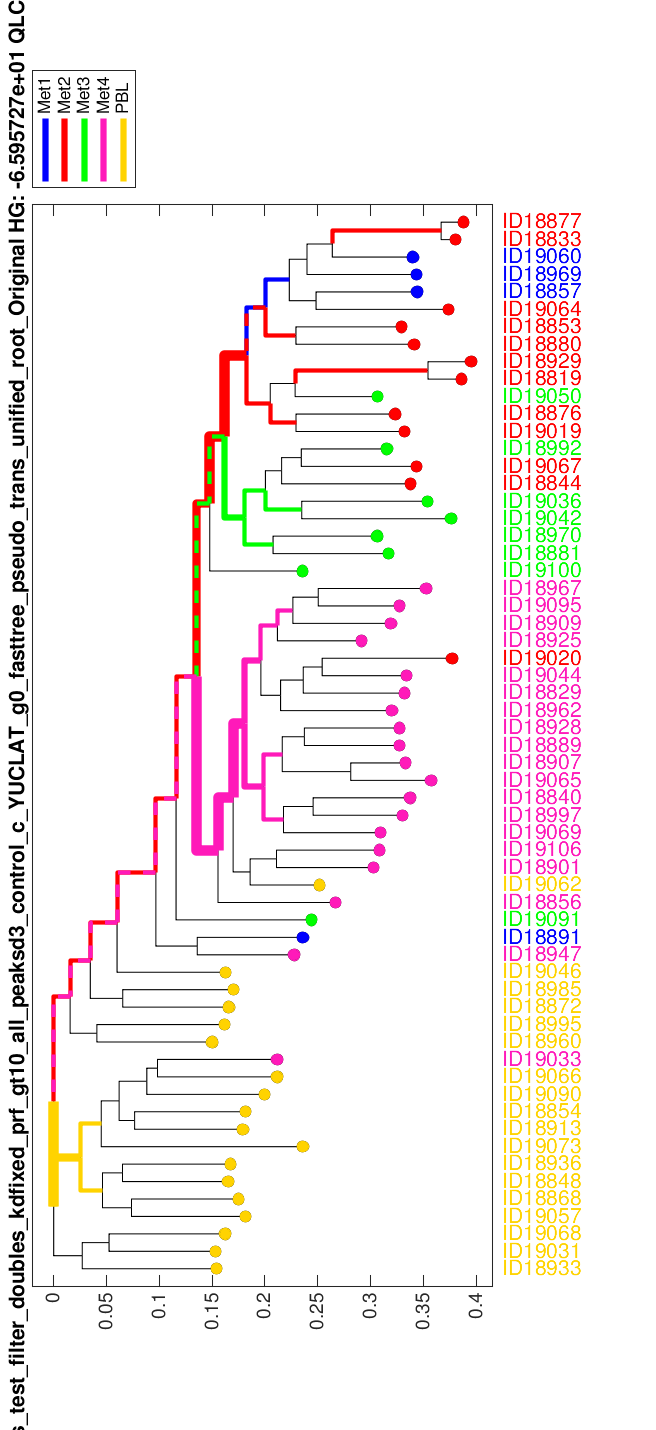

OrderedDict([('HG_score', '-65.957268'), ('QLC_score', '0.551320'), ('TE_score', '0.000000')])
/home/dcsoft/s/trees/22_09_2020/YUCLAT/fasttree_all_clean_doubles_test_filter_doubles_kdfixed_prf_gt10_all_peaksd3_control_c_YUCLAT_g0_fasttree_pseudo_trans_unified_root_Original.newick


In [22]:
from decimal import Decimal
import pickle

a1_col='kd_a1'
a2_col='kd_a2'
p1_col='kd_conf'
p2_col='kd_conf'
conf_thresh = 0.05
min_reads = 0.5*10**6
for ind_id in set(hists_df.individual_id.values):
    ind_name = Individual.objects.get(id=ind_id).name
    if ind_name in ['YUTOGS','LCL440','MM14-23441']:
        print('skipping {}'.format(ind_name))
        continue
    if ind_name not in [
#         'DU145-ex vivo experiment. Seeding started 12032014'
        'YUCLAT',
    ]:
        continue
    ind_df = hists_df[hists_df['individual_id'] == ind_id][hists_df.read_num >= 10]
    ind_df.fillna(0,inplace=True)
    print(ind_df.shape)
    by_ms_groups = ind_df.index.groupby(ind_df.index.get_level_values(1))
    by_sr_groups = ind_df.index.groupby(ind_df.index.get_level_values(2))
    srs = SampleReads.objects.filter(id__in=by_sr_groups.keys(), num_reads__gt=min_reads)
    rldr_srs = [sr for sr in srs if sr.cell.is_root_approximating]
    rldr = ['ID{}'.format(sr.id) for sr in rldr_srs]
    healthy_srs = [sr for sr in list(srs)+rldr_srs]
    filtered_srids = list(set(sr.id for sr in healthy_srs))
    ind_df = ind_df[np.in1d(ind_df.index.get_level_values(2), filtered_srids)]
    by_ms_groups = ind_df.index.groupby(ind_df.index.get_level_values(1))
    by_sr_groups = ind_df.index.groupby(ind_df.index.get_level_values(2))
#     ind_df = add_kd_calling(ind_df, conf=conf_thresh)
#     ind_df.to_pickle('/home/dcsoft/s/Ofir/doubles_test_full_ind_df_with_kd_{}.pickle'.format(ind_name))
    ind_df = asaf_filter(
        ind_df,
        a1_col=a1_col,
        a2_col=a2_col,
        p1_col=p1_col,
        p2_col=p2_col,
        higher_is_better=False,
        p=0.1
    )
    by_ms_groups = ind_df.index.groupby(ind_df.index.get_level_values(1))
    by_sr_groups = ind_df.index.groupby(ind_df.index.get_level_values(2))
    conf_thr = conf_thresh
    bin_map_by_ms = dict()
    for locid in bar(by_ms_groups.keys()):
        high_conf_loc_df = copy_and_filter_peaks(
            ind_df.loc[by_ms_groups[locid]], 
            a1_col=a1_col,
            a2_col=a2_col,
            p1_col=p1_col,
            p2_col=p2_col,
            conf_thr=conf_thr,
            higher_is_better=False)
        try:
            parser = get_asaf_peaks_parser(
                asaf_case_peaks_wrapper(
                    high_conf_loc_df,
                    a1_col=a1_col, 
                    a2_col=a2_col
                ),
#                     find_peaks(
#                         get_flat_data(high_conf_loc_df, a1_col='a1', a2_col='a2'),
#                     minimal_distance_between_peaks=3,
#                         min_prop=0.2,
#                     ),
                max_distance_from_peak=3
            )
            calling_assignments = apply_parser(
                high_conf_loc_df, 
                parser, 
                a1_col=a1_col, 
                a2_col=a2_col)
        except BaseHaplotypingException as e:
            continue

        ica = invert_calling_assignments(calling_assignments)
        bin_map_by_ms[locid] = ica

    d = query_calling_dict_bi(bin_map_by_ms, by_sr_groups.keys(), repeat_type='AC')
    td = transpose_dict(d)
    title = 'fasttree_all_clean_doubles_test_filter_doubles_withmono_kdfixed_prf_gt10_all_peaksd3_control_c'.format(str(conf_thresh))
    rldr_group = 'Original'
    
    print(ind_name, conf_thr)
    with open('/home/dcsoft/s/Ofir/td_cleaned_doubles_test_all__updated4_{}.pickle'.format(ind_name), 'wb') as f:
        pickle.dump(td, f)
    fasta_path, newick_output_path = fastree(td, rldr, ind_name, title, 0, srs, rldr_group)
    print(newick_output_path)